In [1]:
import sys
sys.path.append('../')
import mobipy
import mobipy.optim as opt
import mobipy.stats as stat
import mobipy.plotting as mplt
import numpy as np
import matplotlib.pyplot as plt

import corner

## Note
This notebook will be better documented once the API has stabilized.

In [2]:
modfile = mobipy.mobius2_path() + 'models/simplyq_model.txt'
datfile = mobipy.mobius2_path() + 'models/data/simplyq_simple.dat'
app = mobipy.Model_Application.build_from_model_and_data_file(modfile, datfile, store_all_series=True) 

# Define the model run interval
app.start_date = '2004-01-01'
app.end_date = '2005-12-31'

# Define the interval to calibrate the model on (omitting a few months at the start gives the model some time to 'settle in')
optim_start ='2004-03-01'
optim_end = '2005-12-31'

sl = slice(app.start_date[()], app.end_date[()])

app.run()

True

In [3]:
# Define what parameters to calibrate
par_dict = {
    'bfi' : ("SimplyQ land", "bfi", [], 0, 1),
    'tc_s' : ("SimplyQ land", "tc_s", ["One"], 1, 15),
    'tc_g' : ("SimplyQ land", "tc_g", [], 100, 400),
    'qqinfl' : ("SimplyQ land", "qqinfl", [], 100, 1000),
    'ddf_pet' : ("Degree-day PET", "ddf_pet", [], 0.05, 0.25),
    'pet_min_t' : ("Degree-day PET", "pet_min_t", [], -4, 4),
    'ddf_melt' : ("HBVSnow", "ddf_melt", [], 1, 6)
}

params, set_params = opt.params_from_dict(app, par_dict)
opt.add_wls_params(params, 
                   0.01, 0, 0.05,
                   0.5, 0.01, 1.5)

params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
__mu           0.01        0     0.05     None     True     None     None
__sigma         0.5     0.01      1.5     None     True     None     None
bfi             0.6        0        1     None     True     None     None
ddf_melt          4        1        6     None     True     None     None
ddf_pet        0.16     0.05     0.25     None     True     None     None
pet_min_t         0       -4        4     None     True     None     None
qqinfl          400      100     1000     None     True     None     None
tc_g            200      100      400     None     True     None     None
tc_s              8        1       15     None     True     None     None


In [4]:
# Define the target statistic for the calibration
target = ("Reach flow", "Coull", "Observed Q", ())

get_sim_obs    = opt.residual_from_target(target, optim_start, optim_end)
log_likelihood = opt.ll_from_target(target, optim_start, optim_end)

(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='Date'>)

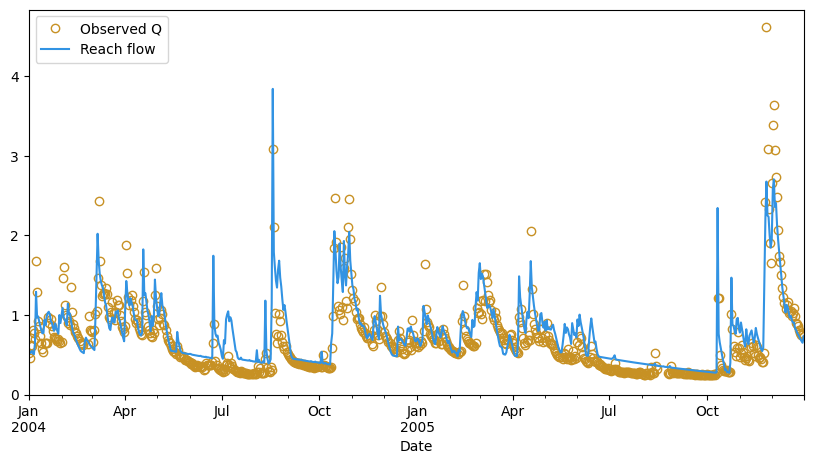

In [5]:
# Plot the model result vs observation before calibration
mplt.plot_targets(app, target, sl)

In [6]:
# Run a minimizer to find a single best parameter set
sim, obs = get_sim_obs(app)
ns_before = stat.nash_sutcliffe(sim, obs)
kg_before = stat.kling_gupta(sim, obs)

res_opt = opt.run_minimizer(app, params, set_params, get_sim_obs)

set_params(app, res_opt.params)
app.run()

sim, obs = get_sim_obs(app)
ns_after = stat.nash_sutcliffe(sim, obs)
kg_after = stat.kling_gupta(sim, obs)

print("Nash-Sutcliffe efficiency: before: %g, after %g" % (ns_before, ns_after))
print("Kling-Gupta efficiency: before: %g, after %g" % (kg_before, kg_after))

Nash-Sutcliffe efficiency: before: 0.754792, after 0.846105
Kling-Gupta efficiency: before: 0.783179, after 0.891467


(<Figure size 1000x500 with 1 Axes>, <Axes: xlabel='Date'>)

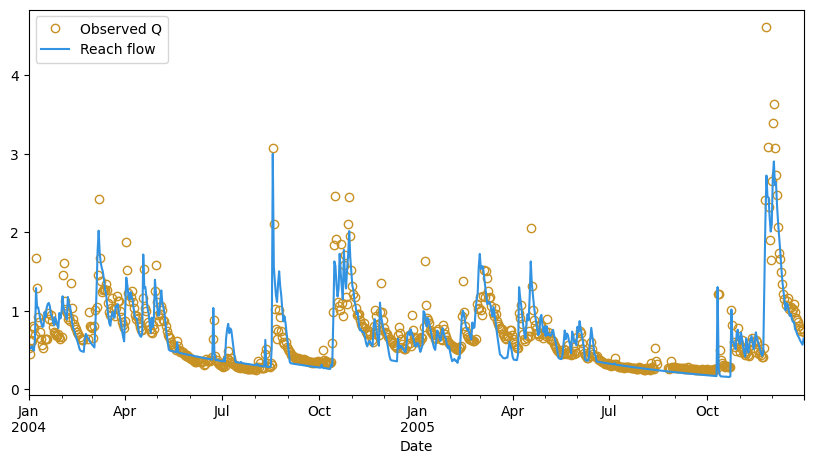

In [7]:
mplt.plot_targets(app, target, sl)

In [8]:
# Run a full MCMC sampling of the parameter space
burn = 1000
steps = 4000 # In practice it should be run with something like 15000 steps
walkers = 50
res = opt.run_mcmc(app, res_opt.params, set_params, log_likelihood, burn=burn, steps=steps, walkers=walkers)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [12:14<00:00,  5.44it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [496.0475173  427.03571599 449.14457296 457.78038276 437.44824493
 454.9639492  471.14709507 412.72947285 465.52309272]


In [9]:
# The summary statistics in the LMFIT results object do not account for the burn-in period, so we correct it.
res = opt.update_mcmc_results(res, burn)

TypeError: 'NoneType' object does not support item assignment

In [ ]:
# Remove burnin and flatten the chains.
chain = res.chain[burn:, :, :]
ndim = res.chain.shape[-1]
samples = chain.reshape((-1, ndim))

# Make a corner plot of the posterior distributions
c = corner.corner(samples, 
              labels=res.var_names, 
              title_args={'fontsize':20},
              label_kwargs={'fontsize':18},
              verbose=False,
              quantiles=[0.025, 0.5, 0.975]
             )

In [ ]:
# Extract max likelihood params from the MCMC run

for i, par_name in enumerate(params):
    params[par_name].value = res.params[var_name].extra['map']
set_params(app, params)

# Run and plot result with these params
app.run()

mplt.plot_targets(app, target, sl)